1) Run drift algorithm with swapped images (for example 2.05 for n1 and 1.05 for n2) so the final deformation would be distributed on a regular grid for 2nd SAR image

In [56]:
import numpy as np
from scipy.interpolate import griddata
from scipy.signal import medfilt2d
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pathlib import Path



%store -r upm
%store -r vpm
%store -r rpm
%store -r hpm
%store -r f1
%store -r f2
%store -r delta_t

  
pixel_size = 2000
cell_size = 2 #ask Anton what they use
N = cell_size

print(upm[55,55])

16300.0


In [57]:
#Filter data for unwanted values and interpolate values into filtered out pixels
#quality filter - thresholding - 'MCC=0.2' (but can be backmatching as well)

quality_filter = (hpm > 0)

def filter_SID(u, v, quality_filter): 

    ''' Filter Sea Ice Drift data <PM_data> with <quality_filter>.

    Parameters
    ----------
         SID_data : sid_classes.PMData
            - Pattern Matching Sea Ice Drift Data
         quality_filter : 2D numpy.ndarray
            - filter mask

    Returns
    -------
         SID_filtered : sid_classes.DriftData
                - filtered SID data
    '''

    # filter mask
    mask      = quality_filter*1
            
    # filter data arrays    
    upmHQ     = u*mask
    vpmHQ     = v*mask
    
    # set no data to nan
    upmHQ[mask==0.0]     = np.nan
    vpmHQ[mask==0.0]     = np.nan
    
    #SID_filtered = (upmHQ, vpmHQ)

    return upmHQ, vpmHQ

def interpolate_SID(upmHQ, vpmHQ, SID_interpolate):

   ''' Interpolate Sea Ice Drift Component Maps of <data_filtered>
       with selected method defined by <config.SID_interpolate>.

    Parameters
    ----------
         data_filtered : sid_classes.DriftData
            - filtered SID data

    Returns
    -------
         SID_interpolated : sid_classes.DriftData
            - interpolated SID data
    '''

   if SID_interpolate == 'linear':

      # XY coordinates for existing values
      mask = (~np.isnan(upmHQ))
      xy   = np.stack((np.nonzero(mask)[0], np.nonzero(mask)[1]), axis=1)

      # corresponding values as list
      u_vals = upmHQ[mask]
      v_vals = vpmHQ[mask]

      # XY coordinates for entire data kernel_size=3grid wanted
      gx, gy = np.mgrid[0:mask.shape[0], 0:mask.shape[1]]
      
      # interpolate values for entire data grid
      u_int = griddata(xy, u_vals, (gx, gy), method='linear')
      v_int = griddata(xy, v_vals, (gx, gy), method='linear')

   if SID_interpolate == 'median':

      # Median filter more appropriate than linear interpolation
      # because it is eliminating variances due to (most likely)
      # incorrect drift retrieval. 

      u_int = medfilt2d(upmHQ)
      v_int = medfilt2d(vpmHQ)

   #SID_interpolated = DriftData(u_int, v_int)

   return u_int, v_int


In [58]:
# filter SID for high quality (line 454 in Sophie's code in Lyb_SID.Py - https://source.coderefinery.org/cirfa/wp2/sea-ice-change-prediction/-/blob/master/lib_SID.py)
upmHQ, vpmHQ = filter_SID(upm,vpm, quality_filter)
# interpolate SID(line 457 in Sophie's code in Lyb_SID.Py)
u_int, v_int = interpolate_SID(upmHQ, vpmHQ, SID_interpolate = 'linear')
u_int.shape

/tmp/ipykernel_17706/4258344919.py:27: RuntimeWarning: invalid value encountered in multiply
  upmHQ     = u*mask
/tmp/ipykernel_17706/4258344919.py:28: RuntimeWarning: invalid value encountered in multiply
  vpmHQ     = v*mask


(149, 159)

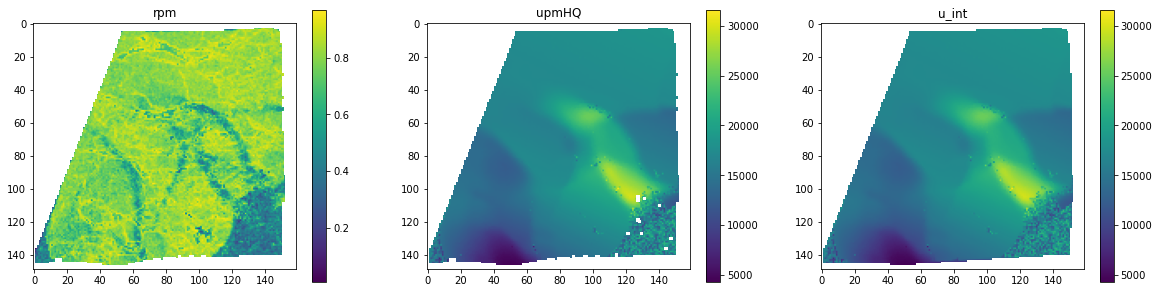

In [59]:
# plot retrieved matrices
titles = ['rpm', 'upmHQ', 'u_int']
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, a in enumerate([rpm, upmHQ, u_int]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

In [60]:
# drift field displacement in pixel
u_map = u_int/pixel_size
v_map = v_int/pixel_size
#u_map = u/pixel_size2
#v_map = v/pixel_size
print(u_int[55,55], u_map[55,55])

16300.0 8.15


In [61]:
#exporting interpolated values
%store u_map
%store v_map

Stored 'u_map' (ndarray)
Stored 'v_map' (ndarray)


In [62]:
def get_averaged_derivatives(u_map, v_map):

    '''     Parameters
    ----------
         u_map : 2D numpy.ndarray
            - Sea Ice Drift Displacement Map East [meter] 
         v_map : 2D numpy.ndarray
            - Sea Ice Drift Displacement Map North [meter]

    Returns
    -------
         U_x : 2D numpy.ndarray
            - averaged derivative of <u_map> with respect to x
         U_y : 2D numpy.ndarray
            - averaged derivative of <u_map> with respect to y
         V_x : 2D numpy.ndarray
            - averaged derivative of <v_map> with respect to x
         V_y : 2D numpy.ndarray
            - averaged derivative of <v_map> with respect to y
    ''' 

    # size of rectangular grid cell
    cell_size = 2 
    N = cell_size

    # area of grid cell
    A = (N)**2
    
    # empty arrays for all four derivatives
    U_x = np.zeros(u_map.shape) + np.nan
    U_y = np.zeros(u_map.shape) + np.nan
    V_x = np.zeros(u_map.shape) + np.nan
    V_y = np.zeros(u_map.shape) + np.nan

    for x in range(0, u_map.shape[1], N):
        for y in range(0, u_map.shape[0], N):

            # access current cell
            u_cell = u_map[y: y+N, x:x+N]
            v_cell = v_map[y: y+N, x:x+N]

            # check for complete data
            if np.sum(np.isnan(u_cell)) or np.sum(np.isnan(v_cell)):
                continue
            
            # skip cells that are not complete (along image edge)
            if not u_cell.shape[0] == N or not u_cell.shape[1] == N:
                continue
            
            # get corner pixel values of grid cell
            uu = get_corner_values(u_cell, N)
            vv = get_corner_values(v_cell, N)
            
            # get corner pixel coordinates of grid cell
            xx, yy = get_corner_coords(x, y, N)
            
            # compute averaged derivative
            u_x = get_derivative(uu, yy,  A)
            u_y = get_derivative(uu, xx, -A)
            v_x = get_derivative(vv, yy,  A)
            v_y = get_derivative(vv, xx, -A)

            # set average value to grid cell 
            U_x[y: y+N, x:x+N] = u_x
            U_y[y: y+N, x:x+N] = u_y
            V_x[y: y+N, x:x+N] = v_x
            V_y[y: y+N, x:x+N] = v_y

    return U_x, U_y, V_x, V_y

def get_derivative(uv, xy, A):

    ''' Compute averaged derivative of drift component <uv> with respect 
        to <xy> and grid cell area <A> according to the approximation of
        the line integral by the trapezoidal rule for discrete values.

    Parameters
    ----------
         uv : 1D numpy.ndarray
            - pixel values of grid cell corners (counter-clockwise)
         xy : 1D numpy.ndarray
            - x/y coordinates of grid cell corners (counter-clockwise)
         A: int
            - grid cell area in pixel

    Returns
    -------
         deriv: float
            - averaged derivative of <uv> with respect to <xy>
    '''
        
    deriv = 0
        
    for i in range(len(uv)-1):
        deriv = deriv + ( (uv[i+1] + uv[i]) * (xy[i+1] - xy[i]) )
    
    deriv = (1/(2*A)) * deriv
    
    return deriv

def get_corner_values(array, N):

    ''' Get all four pixel values for grid cell corners of <array>.

    Parameters
    ----------
         array : 2D numpy.ndarray
            - current grid cell
         N : int
            - size of grid cell

    Returns
    -------
         values : 1D numpy.ndarray
            - pixel values of grid cell corners (counter-clockwise)
    ''' 
    
    # corner values of NxN cell (clockwise)
    c1  = array[0, 0]
    c2  = array[0, N-1]
    c3  = array[N-1, N-1]
    c4  = array[N-1, 0]
    
    values = [c1, c2, c3, c4]   
    
    # flip, such that counter clockwise
    values = np.flip(values)
    
    # add element to close polygon
    values = np.append (values, values[0])
        
    return values

def get_corner_coords(x, y, N):

    ''' Get all four corner coordinates for <N> x <N> grid cell with top 
        left corner at (<x>, <y>).

    Parameters
    ----------
         x : int
            - x coorinate for top left corner of grid cell
         y : int
            - y coorinate for top left corner of grid cell
         N : int
            - size of grid cell

    Returns
    -------
         xx : 1D numpy.ndarray
            - x coordinates of grid cell corners (counter-clockwise)
         yy : 1D numpy.ndarray
            - y coordinates of grid cell corners (counter-clockwise)
    ''' 

    # coordinates of NxN cell (clockwise)
    xx = np.array([x, x+N-1, x+N-1, x])
    yy = np.array([y, y, y+N-1, y+N-1])

    # flip, such that counter clockwise
    xx = np.flip(xx) 
    yy = np.flip(yy)

    # add element to close polygon
    xx = np.append (xx, xx[0])
    yy = np.append (yy, yy[0])

    return xx, yy


def get_div_components(e_div):

    ''' Get positive and negative component maps of <e_div>.

    Parameters
    ----------
         e_div : 2D numpy.ndarray
            - Divergence Map

    Returns
    -------
         div_pos : 2D numpy.ndarray
            - Positive Divergence Map (opening)
         div_neg : 2D numpy.ndarray
            - Negative Divergence Map (closing)
    ''' 

    # create masks
    pos_mask = (e_div > 0)*1
    neg_mask = (e_div < 0)*1
    
    # positive divergence (opening)
    div_pos = np.absolute(e_div * pos_mask)
    div_pos[e_div==0] = np.nan
    
    # negative divergence (closing)
    div_neg = np.absolute(e_div * neg_mask)
    div_neg[e_div==0] = np.nan

    return div_pos, div_neg



In [63]:
# compute averaged partial derivatives of the drift field
U_x, U_y, V_x, V_y = get_averaged_derivatives(u_map, v_map)

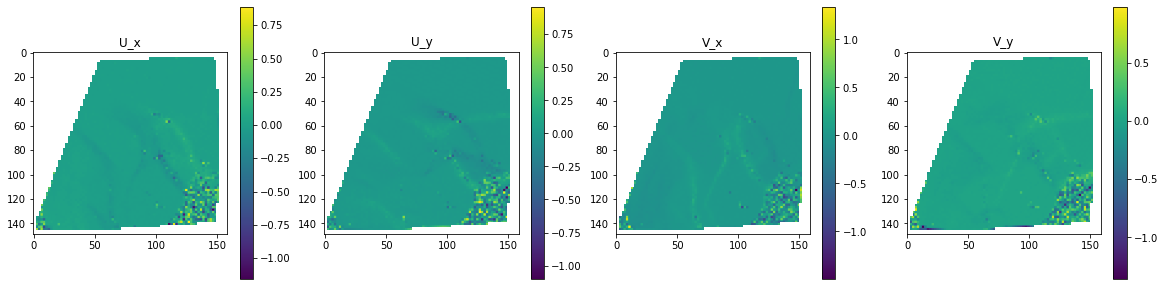

In [64]:
# plot retrieved matrices
titles = ['U_x', 'U_y', 'V_x', 'V_y']
fig, ax = plt.subplots(1,4, figsize=(20,5))
for i, a in enumerate([U_x, U_y, V_x, V_y]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

In [65]:
# compute strain rate parameters
e_div   = U_x + V_y
e_shr   = np.sqrt((U_x - V_y)**2 + (U_y + V_x)**2)
e_tot   = np.sqrt(e_div**2 + e_shr**2)
    
# get divergence components
e_div_pos, e_div_neg = get_div_components(e_div)

print(e_div_pos[55,55])

0.0


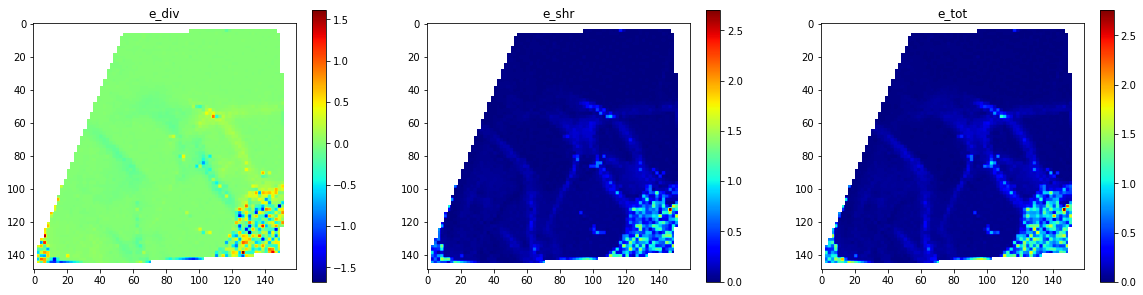

In [66]:
# plot retrieved matrices
titles = ['e_div', 'e_shr', 'e_tot']
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, a in enumerate([e_div, e_shr, e_tot]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a , cmap = 'jet')
    plt.colorbar(im, ax=ax[i])

plt.show()

In [67]:
def get_S1_datestring(f_base):

  datetime = f_base.split('_')[4]
  date     = datetime[0:8]

  yyyy = datetime[0:4];
  mm   = datetime[4:6]
  dd   = datetime[6:8]
  HH   = datetime[9:11]
  MM   = datetime[11:13]
  SS   = datetime[13:15]
  datestring = yyyy + '/' + mm + '/' + dd + ',' + HH + ':' + MM + ':' + SS

  return date, datetime, datestring

In [19]:
#Extracting time information from the file name as a string
f1_name = Path(f1).stem
f2_name = Path(f2).stem

f1_date, f1_datetime, f1_datestring = get_S1_datestring(f1_name)
f2_date, f2_datetime, f2_datestring = get_S1_datestring(f2_name)

print(f1_date, f1_datetime, f1_datestring)
print(f2_date, f2_datetime, f2_datestring)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [58]:
#formatting the time stamp which is in string format to date-time object - now we can get the info through timestamp.hour or timestamp. 
timestamp1 = datetime.strptime(f1_datetime,'%Y%m%dT%H%M%S') #timestamp - acquisition time
timestamp2 = datetime.strptime(f2_datetime,'%Y%m%dT%H%M%S') #timestamp - acquisition time
print(timestamp1, timestamp2)

NameError: name 'f1_datetime' is not defined

In [15]:
#check_time_difference
time_delta_day  = np.abs(timestamp2.day - timestamp1.day)
time_delta      = np.abs(timestamp2 - timestamp1)
dt = time_delta.total_seconds()

# skip processing if larger than a day
if time_delta_day > 1:
    print ("time difference more than one day")
print(time_delta, dt)

NameError: name 'timestamp2' is not defined

In [68]:
dt = delta_t #which one to choose for s2/s2_predict? - just velocities

In [69]:
# initialize DP data object- old name from Sophies code
divergence,convergence, shear, total = e_div_pos, e_div_neg, e_shr, e_tot

# convert DP to rates [1/s]
divergence_sr     = divergence / dt 
convergence_sr    = convergence / dt 
shear_sr          = shear / dt 
total_sr          = total / dt

#total divergence
e_div_sr = e_div / dt


#Convert each Deformation Parameter from rates in [1/s] to [1/d].
DP_scale_factor = (86400 * 100) #100 is for %

divergence_dr     = divergence_sr * DP_scale_factor
convergence_dr    = convergence_sr * DP_scale_factor
shear_dr          = shear_sr * DP_scale_factor
total_dr          = total_sr * DP_scale_factor

e_div_dr = e_div_sr / dt

       
# get DP for time t2 of SAR2 - Resample Deformation Parameter into grid of corresponding second SAR image (SAR2) and assign resampled data array to <SID>. 
#activate function below
divergence_n2     = shift_2D_array_by_SID(divergence_dr, u_map, v_map) 
convergence_n2    = shift_2D_array_by_SID(convergence_dr, u_map, v_map) 
shear_n2          = shift_2D_array_by_SID(shear_dr, u_map, v_map) 
total_n2          = shift_2D_array_by_SID(total_dr, u_map, v_map) 

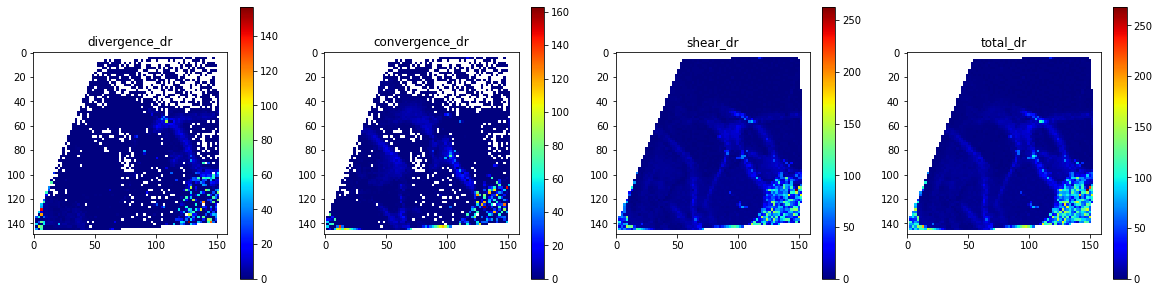

In [70]:
# plot retrieved matrices


titles = ['divergence_dr', 'convergence_dr', 'shear_dr', 'total_dr']
fig, ax = plt.subplots(1,4, figsize=(20,5))
for i, a in enumerate([divergence_dr, convergence_dr, shear_dr, total_dr]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, interpolation ='nearest', cmap = 'jet')
    plt.colorbar(im, ax=ax[i])

plt.show()

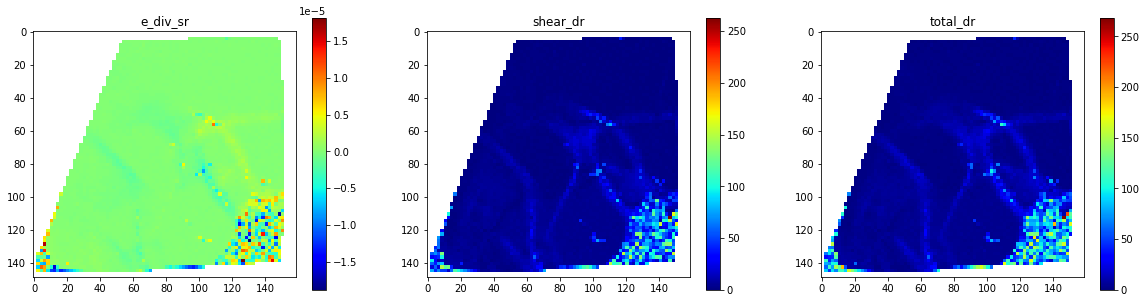

In [71]:
# plot retrieved matrices


titles = ['e_div_sr', 'shear_dr', 'total_dr']
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, a in enumerate([e_div_sr, shear_dr, total_dr]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, interpolation ='nearest', cmap = 'jet')
    plt.colorbar(im, ax=ax[i])

plt.show()

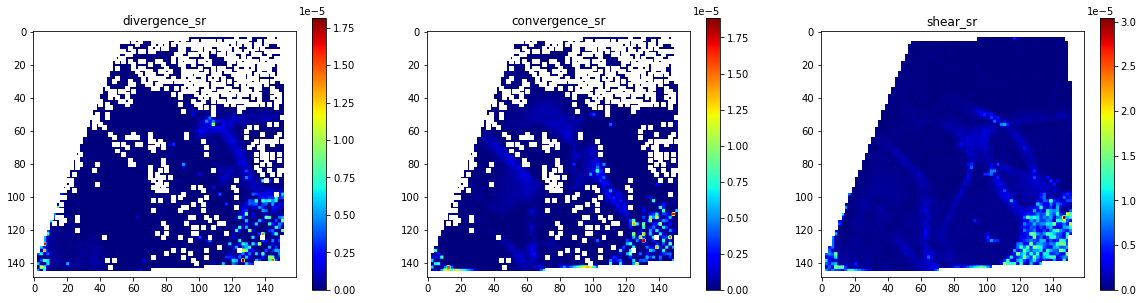

In [72]:
# plot retrieved matrices
titles = ['divergence_sr', 'convergence_sr', 'shear_sr']
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, a in enumerate([divergence_sr, convergence_sr, shear_sr]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, cmap = 'jet')
    plt.colorbar(im, ax=ax[i])

plt.show()

In [73]:
def shift_2D_array_by_SID(array, u_pix, v_pix):

    ''' Shift pixel values of <array> by <u_pix> and <v_pix>.

    Parameters
    ----------
         array : 2D numpy.ndarray
            - input array
         u_pix : 2D numpy.ndarray
            - Sea Ice Drift Displacement Map East [pixel] 
         v_pix : 2D numpy.ndarray
            - Sea Ice Drift Displacement Map North [pixel] 

    Returns
    -------
         array_shifted : 2D numpy.ndarray
            - array with shifted pixel values
    ''' 

    # empty array
    array_shifted = np.zeros(array.shape)
    array_shifted[array_shifted==0] = np.nan

    for x in range(array_shifted.shape[1]):
        for y in range(array_shifted.shape[0]):
            if not np.isnan(u_pix[y, x]) and not np.isnan(v_pix[y, x]):
                xnew = np.round(x - u_pix[y,x]).astype(int)
                ynew = np.round(y + v_pix[y,x]).astype(int)
                if ynew < array.shape[0] and xnew < array.shape[1] and ynew > 0 and xnew > 0:
                    array_shifted[y, x] = array[ynew, xnew]

    return array_shifted


In [74]:
#Need to get new coordinates based on cell size and back??
def upsample(self, grid_xy, dim):
    
        ''' Upsample Deformation Parameter to dimension <dim>.

        Parameters
        ----------
             grid_xy : list
                - data point coordinates (x, y) for all pixels in Deformation
                  Parameter Maps in coordinate system of 2D array with 
                  target dimension <dim>
             dim : list
                - height and width of target dimension
        '''

        self.divergence     = m.upsample_2D(self.divergence, grid_xy, dim, method='nearest')
        self.convergence    = m.upsample_2D(self.convergence, grid_xy, dim, method='nearest')
        self.shear          = m.upsample_2D(self.shear, grid_xy, dim, method='nearest')
        self.total          = m.upsample_2D(self.total, grid_xy, dim, method='nearest')


In [75]:
def upsample_2D(data, grid_src, dim, method='nearest'):

    ''' Upsample 2D array <data> to dimension <dim>.
    
    Parameters
    ----------
         data : 2D numpy.ndarray
            - input array
         grid_src : list
            - data point coordinates (x, y) for all pixels in <data>
              in coordinate system of 2D array with target dimension
              <dim>
         dim : list
            - height and width of target dimension
         method : str
            - interpolation method

    Returns
    -------
         data_up : 2D numpy.ndarray
            - upsampled array
    '''

    # coordinates of existing values
    x_src, y_src    = grid_src
    xy_src          = np.stack((x_src, y_src), axis=1).astype(int)

    # corresponding values
    data_src        = data.flatten()

    # x/y coordinates for destination 2D array
    dst_y, dst_x    = np.mgrid[0:dim[0], 0:dim[1]]

    # subpixel interpolation
    data_up         = griddata(xy_src, data_src, (dst_x, dst_y), method=method)

    return data_up


In [76]:
%store divergence_sr
%store convergence_sr
%store shear_sr
%store total_sr

%store divergence_dr
%store convergence_dr
%store shear_dr
%store total_dr

%store e_div_dr

%store divergence_n2
%store convergence_n2
%store shear_n2
%store total_n2

%store e_tot

Stored 'divergence_sr' (ndarray)
Stored 'convergence_sr' (ndarray)
Stored 'shear_sr' (ndarray)
Stored 'total_sr' (ndarray)
Stored 'divergence_dr' (ndarray)
Stored 'convergence_dr' (ndarray)
Stored 'shear_dr' (ndarray)
Stored 'total_dr' (ndarray)
Stored 'e_div_dr' (ndarray)
Stored 'divergence_n2' (ndarray)
Stored 'convergence_n2' (ndarray)
Stored 'shear_n2' (ndarray)
Stored 'total_n2' (ndarray)
Stored 'e_tot' (ndarray)


In [31]:
mskt = (total_dr>10)
# filter mask
msk_total_dr  = mskt*1

# filter data arrays    
total_dr_msk = total_dr*mskt

# set no data to nan
total_dr_msk[mskt==0.0] = np.nan

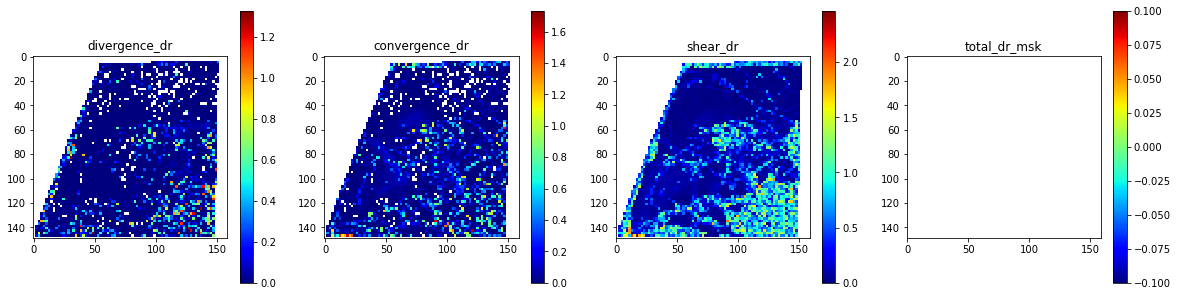

In [32]:
# plot retrieved matrices

titles = ['divergence_dr', 'convergence_dr', 'shear_dr', 'total_dr_msk']
fig, ax = plt.subplots(1,4, figsize=(20,5))
for i, a in enumerate([divergence_dr, convergence_dr, total_dr, total_dr_msk]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, interpolation='nearest', cmap = 'jet')
    plt.colorbar(im, ax=ax[i])

plt.show()

In [35]:
#Mask each Deformation Parameter Map with <mask>.

self.divergence     = m.mask_array(self.divergence, mask, **kwargs)
convergence_mask    = m.mask_array(convergence_dr, mask, **kwargs)
shear_mask          = m.mask_array(shear_dr, mask, **kwargs)
total_mask          = m.mask_array(total_dr, mask, **kwargs)


NameError: name 'm' is not defined

In [34]:
def mask_array(array, mask, zero_vals=np.nan):

    ''' Mask <array> with <mask>.

    Parameters
    ----------
         array : 2D numpy.ndarray
            - input array
         mask : 2D numpy.ndarray
            - filter mask
         zero_vals : int / np.nan 
            - value to set for zero

    Returns
    -------
         masked_array : 2D numpy.ndarray
            - masked array
    '''
    
    # crop with ROI
    masked_array = mask*array
    
    # set '0' to nan
    masked_array[mask==0.0]     = zero_vals
    
    return masked_array


In [369]:
print(1e-06*1000000)

1.0
